In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import svm
import numpy as np
import numpy.random as r 
import matplotlib.pyplot as plt 
import os
import pandas as pd
from copy import deepcopy




Part 1: Data preprocessing


In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv") 

In [3]:
data = data.drop("id", axis = 1) #remove useless features
data = data[data.gender != "Other"]
data.reset_index(drop=True, inplace=True)
data.head(15)

data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5105,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5106,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5107,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Filling null values

In [4]:
data["bmi"][3116]
data["Residence_type"].value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [5]:
bmi_data = data.groupby(["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status", "stroke"])["bmi"].mean()

avg_bmi = data["bmi"].mean()

#assign nan values to the average of samples with matching attributes
for i in range(data["bmi"].shape[0]):
  if np.isnan(data["bmi"][i]):
    data["bmi"][i] = round(bmi_data[data["gender"][i], data["hypertension"][i], data["heart_disease"][i], data["ever_married"][i], data["work_type"][i], data["Residence_type"][i], data["smoking_status"][i], data["stroke"][i]].item(),1)
    if np.isnan(data["bmi"][i]):
        data["bmi"][i] = round(avg_bmi,1)
data[data.isnull().any(axis=1)]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


### One Hot Encoding

In [6]:
# One Hot encoding Here
data_onehot = data.copy()
categorization = {
    "gender": {"Male": 0, "Female": 1},
    "ever_married": {"No":0, "Yes": 1},
    "Residence_type": {"Urban": 0, "Rural": 1}
}
data_onehot = data_onehot.replace(categorization)

smoking_oh = pd.get_dummies(data_onehot['smoking_status'])
worktype_oh = pd.get_dummies(data_onehot['work_type'])
data_onehot = data_onehot.drop('smoking_status', axis=1)
data_onehot = data_onehot.drop('work_type', axis=1)
data_onehot = data_onehot.join(smoking_oh)
data_onehot = data_onehot.join(worktype_oh)
data_onehot

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Unknown,formerly smoked,never smoked,smokes,Govt_job,Never_worked,Private,Self-employed,children
0,0,67.0,0,1,1,0,228.69,36.6,1,0,1,0,0,0,0,1,0,0
1,1,61.0,0,0,1,1,202.21,26.3,1,0,0,1,0,0,0,0,1,0
2,0,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,1,0,0
3,1,49.0,0,0,1,0,171.23,34.4,1,0,0,0,1,0,0,1,0,0
4,1,79.0,1,0,1,1,174.12,24.0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,1,80.0,1,0,1,0,83.75,33.2,0,0,0,1,0,0,0,1,0,0
5105,1,81.0,0,0,1,0,125.20,40.0,0,0,0,1,0,0,0,0,1,0
5106,1,35.0,0,0,1,1,82.99,30.6,0,0,0,1,0,0,0,0,1,0
5107,0,51.0,0,0,1,1,166.29,25.6,0,0,1,0,0,0,0,1,0,0


In [7]:
# Index of what we want to predict.
y_col_ix = data_onehot.columns.get_loc("stroke")
y_col_ix

8

In [8]:
# Numpy version of the data
data_oh_numpy = data_onehot.to_numpy()
data_oh_numpy

array([[ 0., 67.,  0., ...,  1.,  0.,  0.],
       [ 1., 61.,  0., ...,  0.,  1.,  0.],
       [ 0., 80.,  0., ...,  1.,  0.,  0.],
       ...,
       [ 1., 35.,  0., ...,  0.,  1.,  0.],
       [ 0., 51.,  0., ...,  1.,  0.,  0.],
       [ 1., 44.,  0., ...,  0.,  0.,  0.]])

### Splitting the Data

In [9]:
X = np.hstack((data_oh_numpy[:, :y_col_ix], data_oh_numpy[:, y_col_ix+1:]))
y = data_oh_numpy[:, y_col_ix]

### Feature Transformation : Zero-Center + Normalize



In [10]:
# Standard Scaling (Zero mean + unit variance)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[-1.18979109,  1.05124201, -0.32863749, ...,  0.86444434,
        -0.43693145, -0.39415678],
       [ 0.84048369,  0.78588869, -0.32863749, ..., -1.15681248,
         2.28868854, -0.39415678],
       [-1.18979109,  1.6261742 , -0.32863749, ...,  0.86444434,
        -0.43693145, -0.39415678],
       ...,
       [ 0.84048369, -0.3639757 , -0.32863749, ..., -1.15681248,
         2.28868854, -0.39415678],
       [-1.18979109,  0.34363316, -0.32863749, ...,  0.86444434,
        -0.43693145, -0.39415678],
       [ 0.84048369,  0.03405428, -0.32863749, ..., -1.15681248,
        -0.43693145, -0.39415678]])

In [11]:
# 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


# Part 2: Models



## SVM



In [16]:
poly_stats = []
poly_train = []
poly_test = []
for d in range(1, 10):
  poly_svm = svm.SVC(kernel = "poly", degree = d)
  poly_svm.fit(X_train, y_train)
  accuracy_poly_train = poly_svm.score(X_train, y_train)
  accuracy_poly_test = poly_svm.score(X_test, y_test)
  poly_stats.append((round(accuracy_poly_test,6), round(accuracy_poly_train,6)))
  poly_test.append(round(accuracy_poly_test,6))
  poly_train.append(round(accuracy_poly_train,6))


<Figure size 432x288 with 0 Axes>

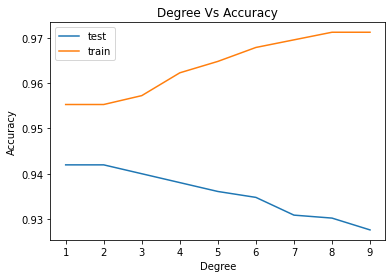

In [17]:
fig1 = plt.figure()
fig1, bx = plt.subplots()

bx.plot([d for d in range(1,10)], poly_test, label = "test")
bx.plot([d for d in range(1,10)], poly_train, label = "train")
bx.set_title("Degree Vs Accuracy")
bx.set_ylabel("Accuracy")
bx.set_xlabel("Degree")
bx.legend()

In [18]:
linear_svm = svm.SVC(kernel = "linear")
linear_svm.fit(X_train, y_train)
accuracy_linear = linear_svm.score(X_test, y_test)
round(accuracy_linear, 6), round(linear_svm.score(X_train, y_train),6)





(0.941944, 0.955257)

In [19]:
linear_svm_r = svm.LinearSVC(penalty="l2", loss="squared_hinge", dual=False)
# linear_svm_r = svm.LinearSVC( dual=False)
# linear_svm_r.fit(X_train, y_train)
linear_svm_r.fit(X_train, y_train)
accuracy_linear_l1_sh = linear_svm_r.score(X_test, y_test)
accuracy_linear_l1_sh


0.9419439008480104

In [20]:
rbf_svm = svm.SVC(kernel = "rbf", gamma = 0.01, C = 1)
rbf_svm.fit(X_train, y_train)
accuracy_rbf = rbf_svm.score(X_test, y_test)
accuracy_rbf

0.9419439008480104

#K-fold Cross Validation

In [23]:

models = ["linear", "poly"]
linear_score_test = []
poly_score_test = []
rbf_score_test = []
linear_score_train = []
poly_score_train = []
rbf_score_train = []
fold = 10
best_models = []
best_scores = {"linear" : (0,0), "poly": (0,0)}

for f in range(2, fold+1):
  kf = StratifiedKFold(n_splits=f, random_state=42, shuffle = True)
  mse = []
  fold_count = 0
  curr_scores = {"linear": (0,0), "poly": (0,0), "rbf": (0,0)}
  for train, test in kf.split(X_scaled, y):
    cx_train, cx_test = X_scaled[train], X_scaled[test]
    cy_train, cy_test = y[train], y[test]
    for model_type in models:
      # if model_type == 'rbf':
      #   model = svm.SVC(kernel = model_type, gamma = 0.01, C = 1)
      # elif model_type == 'linear':
      #   model = svm.LinearSVC()
      # else:
      model = svm.SVC(kernel = model_type)
      model.fit(cx_train, cy_train)
      train_acc = model.score(cx_train, cy_train)
      test_acc = model.score(cx_test, cy_test)
      if test_acc > curr_scores[model_type][0]:
        curr_scores[model_type] = (test_acc, train_acc)
      if best_scores[model_type][0] < test_acc:
        best_scores[model_type] = (test_acc, model.score(X_test, y_test))

  linear_score_test.append(curr_scores["linear"][0])
  poly_score_test.append(curr_scores["poly"][0])
  rbf_score_test.append(curr_scores["rbf"][0])
  linear_score_train.append(curr_scores["linear"][1])
  poly_score_train.append(curr_scores["poly"][1])
  rbf_score_train.append(curr_scores["rbf"][1])




In [24]:
best_scores

{'linear': (0.9529411764705882, 0.9419439008480104),
 'poly': (0.9523809523809523, 0.943900848010437)}

In [ ]:
for i in range(9):
  print(f"Fold: {i+1} | poly test: {round(poly_score_test[i],6)} | polytrain: {round(poly_score_train[i],6)} | linear test: {round(linear_score_test[i],6)} | linear train: {round(linear_score_train[i],6)}")

In [ ]:

# kf = StratifiedKFold(n_splits=10, random_state=42, shuffle = True)
# mse = []
# fold_count = 0
# for train, test in kf.split(X_train, y_train):
#   cx_train, cx_test = X_train[train], X_train[test]
#   cy_train, cy_test = y_train[train], y_train[test]
#   linear_svm = svm.SVC(kernel = "rbf", gamma = 2)
#   linear_svm.fit(cx_train, cy_train)
#   accuracy_linear = linear_svm.score(cx_test, cy_test)
#   print(accuracy_linear)
  

<Figure size 432x288 with 0 Axes>

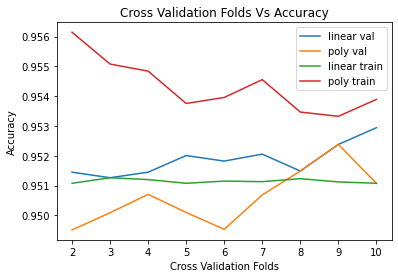

In [26]:
val = [n for n in range(2, 11)]
fig = plt.figure()
fig, ax = plt.subplots()
ax.plot(val, linear_score_test, label = 'linear val')
ax.plot(val, poly_score_test, label = 'poly val')
ax.plot(val, linear_score_train, label = 'linear train')
ax.plot(val, poly_score_train, label = 'poly train')
# ax.plot(val, rbf_score, label = 'rbf')
ax.set_xlabel("Cross Validation Folds")
ax.set_ylabel("Accuracy")
ax.set_title("Cross Validation Folds Vs Accuracy")
ax.legend()